Using the shot chart avaialable for each nba player via the nba api to create a machine learning routine that should be capable of predicting whether or not a basket will go in.

Variables include position, coverage, and time. 

Making it one big function that way as soon as you end the player, its done

All this analysis is data science, machine learning is the clustering stuff. 

Shot Chart Analysis
===========


In this notebook, available shot chart data avalaible via the nba api "nba_py" is leveraged in order to characterize a given NBA player's behavior on the court. 


Additionally different Machine Learning routines are used in order to help predict the outcome of a particular shot. By accounting for the position of the player during the shot, as well as what form it is (jump shot, post up, fade away, etc.). These routines are found to yield a relatively successful result, aswell as help identify the players hot and cold spots. 


In [1]:
from nba_py import player
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(4)  #replication purposes.
import matplotlib.pyplot as plt
from sklearn import preprocessing, cross_validation, neighbors
from sklearn.neural_network import MLPClassifier
from nba_py import shotchart
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import nba_py

In [3]:
day = nba_py.Scoreboard()

In [ ]:
day.line_score()

In [ ]:
players = player.PlayerList()

In [ ]:
playersdf = players.info()

In [ ]:
playersdf

In [ ]:
PIDs = playersdf['PERSON_ID'].valuues

In [ ]:
stevenadams = 203500

In [ ]:
chart = shotchart.ShotChart(stevenadams)
chartdf = chart.shot_chart()

In [ ]:
chartdf

In [ ]:
for PID in PIDs:
    print(PID)

In [4]:
def get_PID(first_name,last_name):
    """Obtains the player ID number of the desired player.
    
    Parameters
    -----------
    
    first_name: str
        First name of player
    last_name: str
        Last name of player
    
    Returns
    -------
    
    ID : float
        The player's ID number. 
    """
    
    playa = player.get_player(first_name=first_name,last_name=last_name)
    
    return playa.values[0]
def get_shotchart(PID):
    """Returns a dataframe of the shotchart.
    """
    chart = shotchart.ShotChart(PID)
    chartdf = chart.shot_chart()
  #  print("head")
  #  print(chartdf.head())
  #  importantstuff = chartdf[['LOC_X','LOC_Y','SHOT_DISTANCE','ACTION_TYPE','EVENT_TYPE']].copy()   #['LOC_X','LOC_Y','EVENT_TYPE']
    importantstuff = chartdf[['LOC_X','LOC_Y','ACTION_TYPE','EVENT_TYPE']].copy()
    importantstuff = pd.get_dummies(importantstuff)
    return importantstuff

In [5]:
def analyze_player(first,last,plot=True,regcluster=True,Classifier=True,spectralcluster=True):
    """Wrapper function which does everything in one, 
    no need to specify each table specific to that player right away!
    
    Parameters
    -----------
    first and last name of the player, comma separated, string format. 
    
    and a plotting option to see the shot chart, and anything else if I think of it. 
    and a cluster option to try and use ML to predict whether or not a shot goes in!
    
    Returns
    -------
    
    Shot chart, clustering success, anything else
    """
    
    
    PID = get_PID(first,last)
    print(first,last,'PID',PID)
    playertable =  get_shotchart(PID)
    #print(playertable)
    if plot: 
        makes = playertable.loc[playertable['EVENT_TYPE_Missed Shot'] == 0]
        misses = playertable.loc[playertable['EVENT_TYPE_Missed Shot'] == 1]
        xmade = makes['LOC_X'].values/10
        ymade = makes['LOC_Y'].values/10
        xmissed = misses['LOC_X'].values/10
        ymissed = misses['LOC_Y'].values/10
        x = np.linspace(-60,60,100)
        #make a 3pt line for reference
        for i in range(len(x)):
            r = 22
            y = np.sqrt(r**2 - x**2)
        plt.plot(xmade,ymade,'mo',label = 'made')
        plt.plot(xmissed,ymissed,'yx',label = 'missed')
        plt.plot(x,y,'k-',label = '~3pt line')
        plt.xlim((-25, 25))  
        plt.ylim((0, 35))  

        plt.title("Shot Chart of " + first + " " + last)
        plt.xlabel('dist. from hoop (ft)')
        plt.ylabel('dist. from hoop (ft)')

        plt.legend()
        y = playertable[['EVENT_TYPE_Made Shot','EVENT_TYPE_Missed Shot']].values
        del playertable['EVENT_TYPE_Made Shot'],playertable['EVENT_TYPE_Missed Shot']
        X = playertable.values
    if regcluster:
        scaler = MinMaxScaler()
        MinMaxScaler(copy=True, feature_range=(0, 1))
        #neuaral net needs to be normalized, not clustering... would it matter? 
        scaler.fit(X)
        X = scaler.transform(X)
        X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size=0.2)
        clf = neighbors.KNeighborsClassifier()
        clf.fit(X_train,y_train)
        accuracy = clf.score(X_test,y_test)
        print("Accuracy of clustering:",100*accuracy,"%.")
    if Classifier:
        #try a NN, whatever
        #normalize rgith ere 
        scaler = MinMaxScaler()
        MinMaxScaler(copy=True, feature_range=(0, 1))
        #neuaral net needs to be normalized, not clustering... would it matter? 
        scaler.fit(X)
        X = scaler.transform(X)
        X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size=0.2)
        model = MLPClassifier()
        model.shuffle = True
        model.fit(X_train,y_train)
        accuracy = model.score(X_test,y_test)
    
        print("Accuracy of MLP Classifier:",100*accuracy,"%.")
    if spectralcluster:

        scaler = MinMaxScaler()
        MinMaxScaler(copy=True, feature_range=(0, 1))
        #neuaral net needs to be normalized, not clustering... would it matter? 
        scaler.fit(X)
        X = scaler.transform(X)
        X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size=0.2)
        clf = SpectralClustering(n_clusters=2)
        clf.fit(X_train,y_train)
        accuracy = model.score(X_test,y_test)
        print("Accuracy of Spectral Clustering:",100*accuracy,"%.")



Lebron James PID 2544


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in sqrt
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Accuracy of clustering: 61.39240506329114 %.
Accuracy of MLP Classifier: 66.45569620253164 %.
Accuracy of Spectral Clustering: 68.0379746835443 %.


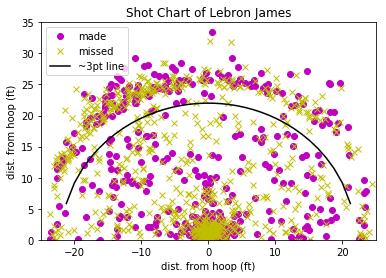

In [6]:
analyze_player('Lebron','James')

In [ ]:
def analyze_players(plot=False,regcluster=True,Classifier=True,spectralcluster=True):
    """Wrapper function which does everything in one, 
    no need to specify each table specific to that player right away!
    

    Parameters
    -----------
    PIDSs. Array of all the active nba players, just to see which is best for fitting etc.     
    
    Returns
    -------
    
    Shot chart, clustering success, anything else
    """
    
    players = player.PlayerList() 
    
    playersdf = players.info()
    PIDs = playersdf['PERSON_ID'].values
    names = playersdf['DISPLAY_FIRST_LAST'].values
    for i in range(len(PIDs)):
        PID = PIDs[i]
        name = names[i]
        print(name)
        playertable =  get_shotchart(PID)
    #print(playertable)
        if plot: 
            makes = playertable.loc[playertable['EVENT_TYPE_Missed Shot'] == 0]
            misses = playertable.loc[playertable['EVENT_TYPE_Missed Shot'] == 1]
            xmade = makes['LOC_X'].values/10
            ymade = makes['LOC_Y'].values/10
            xmissed = misses['LOC_X'].values/10
            ymissed = misses['LOC_Y'].values/10
            x = np.linspace(-60,60,100)
        #make a 3pt line for reference
            for i in range(len(x)):
                r = 22
                y = np.sqrt(r**2 - x**2)
            plt.plot(xmade,ymade,'mo',label = 'made')
            plt.plot(xmissed,ymissed,'yx',label = 'missed')
            plt.plot(x,y,'k-',label = '~3pt line')
            plt.xlim((-25, 25))  
            plt.ylim((0, 35))  

            plt.title("Shot Chart of " + first + " " + last)
            plt.xlabel('dist. from hoop (ft)')
            plt.ylabel('dist. from hoop (ft)')

            plt.legend()
        y = playertable[['EVENT_TYPE_Made Shot','EVENT_TYPE_Missed Shot']].values
        del playertable['EVENT_TYPE_Made Shot'],playertable['EVENT_TYPE_Missed Shot']
        X = playertable.values
        if cluster:
            X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size=0.2)
            clf = neighbors.KNeighborsClassifier()
            clf.fit(X_train,y_train)
            accuracy = clf.score(X_test,y_test)
            print("Accuracy of clustering:",100*accuracy,"%.")
        if Classifier:
        #try a NN, whatever
        #normalize rgith ere 
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            MinMaxScaler(copy=True, feature_range=(0, 1))

            scaler.fit(X)
            X = scaler.transform(X)
            X_train,X_test,y_train,y_test = cross_validation.train_test_split(X,y,test_size=0.2)
            model = MLPClassifier()
            model.shuffle = True
            model.fit(X_train,y_train)
            accuracy = model.score(X_test,y_test)

            print("Accuracy of MLP Classifier:",100*accuracy,"%.")


In [ ]:
analyze_players()

In [ ]:
analyze_player('Alexis','Ajinca')

If I had to guess these lines are on the line, so approximately speaking 220 of these units corresponds to 22 feet. Ie divide by 10 to obtain feet. Doing this now!

In [ ]:
plt.plot(x,y)